In [39]:
from argparse import Namespace 
import torch
import numpy as np
from torch.utils.data import DataLoader
from src.detector.data_obj_detect import MOT16ObjDetect
from src.detector.utils import obj_detect_transforms

args = Namespace()
args.data_root_dir = "data/MOT16/train"
args.vis_threshold = 0.25
args.num_workers = 0
args.batch_size = 2

dataset_test = MOT16ObjDetect(
        root=args.data_root_dir,
        transforms=obj_detect_transforms(train=False),
        vis_threshold=args.vis_threshold,
        segmentation=True
    )

data_loader_test = DataLoader(
    dataset_test,
    batch_size=args.batch_size,
    shuffle=False,
    num_workers=args.num_workers,
    collate_fn=lambda batch: tuple(zip(*batch)),
)

In [40]:
images, targets = next(iter(data_loader_test))

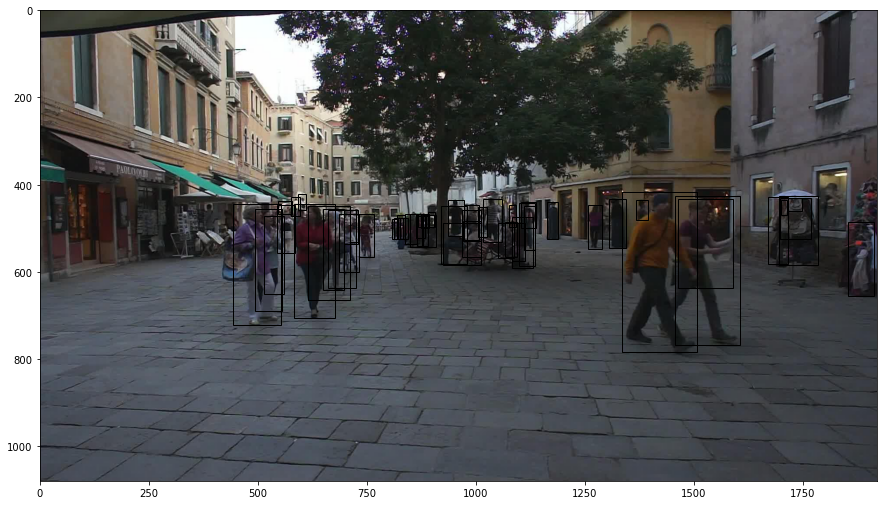

In [34]:
from PIL import Image
import torchvision.transforms.functional as TF
import torch
import torchvision
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from src.tracker.data_track_precomputed import MOT16SequencesPrecomputed
from src.utils.torch_utils import dict2keys_and_items

sequences = MOT16SequencesPrecomputed(
        precomputed_data_root_dir="data/precomputed_detection/fasterrcnn",
        original_data_root_dir="data/MOT16",
        split="train",
        vis_threshold=0.0,
)


sequence = sequences[0]
frame = sequence[0]


fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(frame["img"].permute(1, 2, 0))
for box in frame["boxes"]:
    x, y, w, h = torchvision.ops.box_convert(box, "xyxy", "xywh")
    ax.add_patch(Rectangle((x, y), w, h, fill=False))

# for id, box in frame["gt"].items():
#     x, y, w, h = torchvision.ops.box_convert(torch.from_numpy(box), "xyxy", "xywh")
#     ax.add_patch(Rectangle((x, y), w, h, fill=False))



In [25]:

# write existing database to my folder structure
import os
from src.utils.file_utils import ensure_dir
from src.tracker.data_track import MOT16Sequence
from tqdm import tqdm
db = torch.load("data/precomputed_detection/chair/preprocessed_data_train_2.pth")
dir = "data/precomputed_detection/default"

for seq_name in tqdm(db.keys(), desc="seqs"):
    dets = []
    for frame_id, frame in enumerate(db[seq_name], start=1):
        det = {"boxes": frame["det"]["boxes"], "scores": frame["det"]["scores"]}
        dets.append(det)
        reid_on_gt = frame["gt"]["reid"]
        reid_on_det = frame["det"]["reid"]
        reid_on_gt_path = os.path.join(dir, seq_name, "reid", "reid_on_gt", f"{frame_id:06d}.pth")
        reid_on_det_path = os.path.join(dir, seq_name, "reid", "reid_on_det", f"{frame_id:06d}.pth")
        ensure_dir(reid_on_gt_path)
        ensure_dir(reid_on_det_path)
        torch.save(reid_on_gt, reid_on_gt_path)
        torch.save(reid_on_det, reid_on_det_path)

    det_path = os.path.join(dir, seq_name, "detection.pth")
    ensure_dir(det_path)
    torch.save(dets, det_path)

        
    

seqs: 100%|██████████| 7/7 [00:07<00:00,  1.10s/it]


In [14]:
# create new detector
import json
import torch
from src.detector.object_detector import init_detector_from_config

obj_detect_path = "config/obj_detect/maskrcnn.json"
save_path = "models/obj_detect/default_maskrcnn.pth"
with open(obj_detect_path, "r") as f:
    config = json.load(f)

obj_detect = init_detector_from_config(config)
torch.save(obj_detect, save_path)

In [24]:
# create new assign model
import json
import torch
from src.gnn.assignment_model import AssignmentWeightedAverage

config_path = "config/assign_model/mask_and_box_iou.json"
save_path = "models/assign_model/mask_and_box_iou.pth"
with open(config_path, "r") as f:
    config = json.load(f)

assign_model = AssignmentWeightedAverage.from_config(config)
torch.save(assign_model, save_path)

In [76]:
not not {}

False

In [1]:
import pandas as pd
import json
import numpy as np
import torch
import argparse
import matplotlib.pyplot as plt
import torchvision
from matplotlib.patches import Rectangle
from src.tracker.tracker import MyTracker
from src.tracker.data_track_precomputed import MOT16SequencesPrecomputed
from src.tracker.data_track import load_detection_from_txt

txt_path = "results\\tracker\\06-04-2022_23-53\\tracker_predictions_MOT16-mini\\MOT16-02-mini.txt"
det = load_detection_from_txt(txt_path, vis_threshold=0.0, mode="track")


df = pd.read_csv("events.csv")
with open("results\\tracker\\06-04-2022_23-53\\eval_config.json", "r") as f:
    eval_config = json.load(f)
args = argparse.Namespace(**eval_config)
dataset = f"MOT16-{args.split}"
with open(args.tracker_config_path, "r") as f:
    tracker_hyperparams = json.load(f)

# execute
tracker = MyTracker.from_config(tracker_hyperparams)
sequences = MOT16SequencesPrecomputed(
        precomputed_data_root_dir=args.precomputed_data_root_dir,
        original_data_root_dir=args.original_data_root_dir,
        split=args.split,
        vis_threshold=args.vis_threshold,
        return_det_segmentation=tracker.assign_model.use_segmentation,
        return_gt_segmentation=tracker.assign_model.use_segmentation,
)
sequence = sequences[0]

In [274]:
dfs = [df, df]
names = ["MOT16-02", "MOT16-03"]

In [305]:
concat_df = pd.concat(dfs)

In [303]:

multi_idx_tuples = []
for seq_name, df in zip(names, dfs):
    multi_idx_tuples.extend(list(zip([seq_name for _ in df.index], df.index)))
multi_idx = pd.MultiIndex.from_tuples(multi_idx_tuples)

In [311]:
concat_df.index = multi_idx
concat_df.loc["MOT16-03"]







,FrameId,Event,Type,OId,HId,D
0,0,484,MATCH,2.0,0.0,0.099877
1,0,485,MATCH,3.0,1.0,0.079512
2,0,486,MATCH,8.0,2.0,0.274191
3,0,487,MATCH,10.0,18.0,0.405730
4,0,488,MATCH,14.0,3.0,0.199545
...,...,...,...,...,...,...
668,19,487,FP,NaN,21.0,NaN
669,19,488,FP,NaN,32.0,NaN
670,19,489,FP,NaN,42.0,NaN
671,19,490,FP,NaN,43.0,NaN


In [83]:
# TODO
# train / evaluate / precompute reid model
# analyze correlation of FP/FN/SWITCH with lumination/size/
# visualize maskrcnn segmentations per frame
# visualize identity switches
# rewrite detector evaluation saving from pth to txt -> for practicality, so that you can load detections in the gt_dict format
# write visualization that differentiates detector fp/tp from tracker fp/tp -> we need to differentiate between detector mistakes and assign_model mistakes

In [81]:
# MISTAKE LEGEND
# TP (SWITCH + MATCH) is a correct detection, but switch / match determines wether it was matched correctly to previous track
# FP can happen as a detector mistake or if the tracker has a separate box generation method
# FN (MISS) can happen as a detector mistake or if the tracker has a separate box generation method
# SWITCH is not a detection mistake, it is a pure identity mistake and it happens when the assign_model outputs a similiarity value below the threshold for the same object in two different frames, so a new track is started.

In [ ]:
# Problems:
# FN
# - slight occlusion by other pedestrian -> reduce nms thresh
# - full occlusion by pedestrian/obj -> reidentify
# - small 
# - bad lumination
# FP 
# - shape similiar to human -> check for movement (optical flow)
# - static humans have no gt, but paper says its no problem

In [7]:
import torch
list(zip(torch.ones(3), [1, 2, 3]))

[(tensor(1.), 1), (tensor(1.), 2), (tensor(1.), 3)]

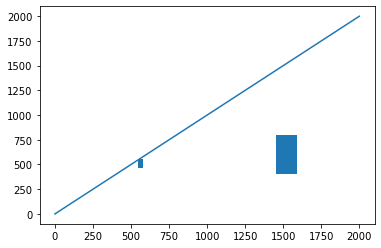

In [27]:
box1 = torch.tensor([ 546.0731,  461.8880,  580.8127,  555.6319])
box2 = torch.tensor([1452.5284,  408.1602, 1592.4258,  802.0670])
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import torchvision
fig, ax = plt.subplots()
ax.plot(range(2000), range(2000))
box1 = torchvision.ops.box_convert(box1, "xyxy", "xywh")
box2 = torchvision.ops.box_convert(box2, "xyxy", "xywh")
ax.add_patch(Rectangle(box1[:2], box1[2], box1[3]))
ax.add_patch(Rectangle(box2[:2], box2[2], box2[3]))

# der fehler ist beim matching

In [1]:
from src.tracker.visualization import get_visualization_functions

sequence_dir = "results\\tracker\\07-04-2022_18-30\\MOT16-02"
vis_functions = get_visualization_functions(sequence_dir)


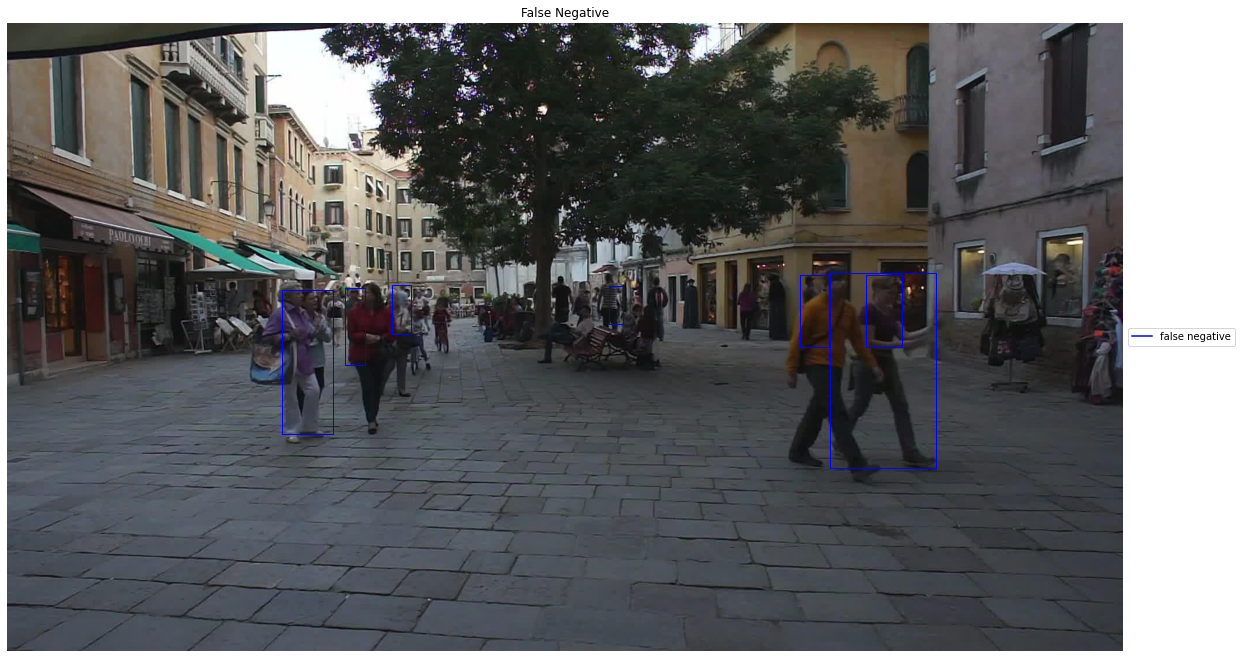

In [3]:
vis_functions["detections"](0, "MISS")